In [1]:
import os

import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, LeakyReLU, BatchNormalization, Concatenate, Conv2DTranspose, Dropout

from PIL import Image

In [2]:
# задаём константы
IMG_WIDTH = 640                       # Ширина итогового изображения
IMG_LENGTH = 768                      # Длина итогового изображения
IMG_SHAPE  = (IMG_WIDTH, IMG_LENGTH)  # Формат изображения (ширина, длина)
CLASSES = 6                           # Число классов сегментирования

In [3]:
def download_data(path):
    data = []
    for path_image in sorted(os.listdir(path=path)):
        image = Image.open(path + path_image) #Открываем изображение.
        image = tf.image.resize(image, IMG_SHAPE)
        data.append(np.array(image)) #Загружаем пиксели.
    return data

In [4]:
X_train = download_data("train/images/")
Y_train = download_data("train/masks/")

In [5]:
X_test = download_data("test/images/")
Y_test = download_data("test/masks/")

### Функции предобработки и пост обработки данных

In [6]:
# Атрибут palette используется для установки цвета полос. Это помогает различать данные
palette = {0: (60, 16, 152), # Building
           1: (132, 41, 246), # Land
           2: (110, 193, 228), # Road
           3: (254, 221, 58), # Vegetation
           4: (226, 169, 41), # Water|
           5: (155, 155, 155)} # Unlabeled

In [7]:
# Переменная invert_palette позволяет проводить обратное преобразование, цвета в метку класса
invert_palette = {v: k for k, v in palette.items()}

In [8]:
# сегментация нейронной сети в RGB изображение
def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)
    
    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i
    
    return arr_3d

In [9]:
# функция преобразует результат сегментации нейронной сети в RGB изображение, удобное для восприятия пользователя
def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    # принадлежность каждого пикселя классу
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.int8)
    # расстояние до ближайшего класса для пикселей
    min_distance = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.float32)+1000
    for c, i in palette.items():
        # ищем расстояние для каждого пикселя до проверяемого класса по евклиду рас-ие
        distance = np.sum((arr_3d - np.array(c).reshape(1, 1, 3))**2, axis=-1)**(1/2)
        # поиск элементов меньше min_distance
        condition = min_distance > distance
        # замена дистанции найденных элементов
        min_distance[condition] = distance[condition]
        # замена класса найденных элементов
        arr_2d[condition] = i

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    arr_2d = arr_2d.tolist()
    for i in range(len(arr_2d)):
        for j in range(len(arr_2d[0])):
            label = [0, 0, 0, 0, 0, 0]
            label[arr_2d[i][j]] = 1
            arr_2d[i][j] = label
    arr_2d = np.array(arr_2d)

    return arr_2d

### Предобработка исходных изображений и сегментированных изображений в ответ сети

In [10]:
# Следующий блок кода подготавливает данные для использования нейронной сетью
X_train_pred = np.array(X_train).reshape([7, IMG_WIDTH, IMG_LENGTH, 3])/255 
X_test_pred = np.array(X_test).reshape([2, IMG_WIDTH, IMG_LENGTH, 3])/255   

In [11]:
Y_train_pred = []
for i in range(len(Y_train)):
    Y_train_pred.append(convert_from_color(Y_train[i][:, :, :3]))
Y_train_pred = np.array(Y_train_pred)

In [12]:
Y_test_pred = []
for i in range(len(Y_test)):
    Y_test_pred.append(convert_from_color(Y_test[i][:, :, :3]))
Y_test_pred = np.array(Y_test_pred)

In [13]:
X_train_pred.shape

(7, 640, 768, 3)

### Объявление топологии нейронной сети, компиляция и обучение

In [14]:
def unet_model(image_size, output_classes):

    #Входной слой
    input_layer = Input(shape=image_size + (3,))
    conv_1 = Conv2D(64, 4, 
                    activation=LeakyReLU(),
                    strides=2, 
                    padding='same', 
                    kernel_initializer='glorot_normal', 
                    use_bias=False)(input_layer)
    
    #Сворачиваем
    conv_1_1 = Conv2D(128, 4, 
                      activation=LeakyReLU(), 
                      strides=2, 
                      padding='same', 
                      kernel_initializer='glorot_normal', 
                      use_bias=False)(conv_1)
    batch_norm_1 = BatchNormalization()(conv_1_1)

    #2
    conv_2 = Conv2D(256, 4, 
                    activation=LeakyReLU(), 
                    strides=2, 
                    padding='same', 
                    kernel_initializer='glorot_normal', 
                    use_bias=False)(batch_norm_1)
    batch_norm_2 = BatchNormalization()(conv_2)

    #3
    conv_3 = Conv2D(512, 4, 
                    activation=LeakyReLU(), 
                    strides=2, 
                    padding='same', 
                    kernel_initializer='glorot_normal', 
                    use_bias=False)(batch_norm_2)
    batch_norm_3 = BatchNormalization()(conv_3)

    #4
    conv_4 = Conv2D(512, 4, 
                    activation=LeakyReLU(), 
                    strides=2, 
                    padding='same', 
                    kernel_initializer='glorot_normal', 
                    use_bias=False)(batch_norm_3)
    batch_norm_4 = BatchNormalization()(conv_4)

    #5
    conv_5 = Conv2D(512, 4, 
                    activation=LeakyReLU(), 
                    strides=2, 
                    padding='same', 
                    kernel_initializer='glorot_normal', 
                    use_bias=False)(batch_norm_4)
    batch_norm_5 = BatchNormalization()(conv_5)

    #6
    conv_6 = Conv2D(512, 4, 
                    activation=LeakyReLU(), 
                    strides=2, 
                    padding='same', 
                    kernel_initializer='glorot_normal', 
                    use_bias=False)(batch_norm_5)

    #Разворачиваем
    #1
    up_1 = Concatenate()([
        Conv2DTranspose(512, 4, 
                         activation='relu', 
                         strides=2, 
                         padding='same', 
                         kernel_initializer='glorot_normal', 
                         use_bias=False)(conv_6), 
        conv_5
    ])
    batch_up_1 = BatchNormalization()(up_1)

    #Добавим Dropout от переобучения
    batch_up_1 = Dropout(0.25)(batch_up_1)

    #2
    up_2 = Concatenate()([
        Conv2DTranspose(512, 4, 
                        activation='relu', 
                        strides=2, 
                        padding='same', 
                        kernel_initializer='glorot_normal', 
                        use_bias=False)(batch_up_1), 
        conv_4
    ])
    batch_up_2 = BatchNormalization()(up_2)
    batch_up_2 = Dropout(0.25)(batch_up_2)

    #3
    up_3 = Concatenate()([
        Conv2DTranspose(512, 4, 
                        activation='relu', 
                        strides=2, 
                        padding='same', 
                        kernel_initializer='glorot_normal', 
                        use_bias=False)(batch_up_2), 
        conv_3
    ])
    batch_up_3 = BatchNormalization()(up_3)
    batch_up_3 = Dropout(0.25)(batch_up_3)

    #4
    up_4 = Concatenate()([
        Conv2DTranspose(256, 4, 
                        activation='relu', 
                        strides=2, 
                        padding='same', 
                        kernel_initializer='glorot_normal', 
                        use_bias=False)(batch_up_3), 
        conv_2
    ])
    batch_up_4 = BatchNormalization()(up_4)

    #5
    up_5 = Concatenate()([
        Conv2DTranspose(128, 4, 
                        activation='relu', 
                        strides=2, 
                        padding='same', 
                        kernel_initializer='glorot_normal', 
                        use_bias=False)(batch_up_4), 
        conv_1_1
    ])
    batch_up_5 = BatchNormalization()(up_5)

    #6
    up_6 = Concatenate()([
        Conv2DTranspose(64, 4, 
                        activation='relu', 
                        strides=2, 
                        padding='same', 
                        kernel_initializer='glorot_normal', 
                        use_bias=False)(batch_up_5), 
        conv_1
    ])
    batch_up_6 = BatchNormalization()(up_6)

    #Выходной слой
    output_layer = Conv2DTranspose(output_classes, 4, 
                                   activation='sigmoid', 
                                   strides=2, 
                                   padding='same', 
                                   kernel_initializer='glorot_normal')(batch_up_6)

    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [15]:
model = unet_model(image_size=IMG_SHAPE, output_classes=CLASSES)

In [16]:
#Компилируем модель
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 640, 768, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 320, 384, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 160, 192, 12  131072      ['conv2d[0][0]']                 
                                8)                                                            

 spose)                         8)                                                                
                                                                                                  
 concatenate_4 (Concatenate)    (None, 160, 192, 25  0           ['conv2d_transpose_4[0][0]',     
                                6)                                'conv2d_1[0][0]']               
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 160, 192, 25  1024       ['concatenate_4[0][0]']          
 rmalization)                   6)                                                                
                                                                                                  
 conv2d_transpose_5 (Conv2DTran  (None, 320, 384, 64  262144     ['batch_normalization_9[0][0]']  
 spose)                         )                                                                 
          

In [17]:
# Обучаем модель
history = model.fit(X_train_pred,
                    Y_train_pred,
                    batch_size=1,
                    epochs=100,
                    validation_data=(X_test_pred, Y_test_pred))

Epoch 1/100
7/7 [==============================] - 10s 1s/step - loss: 1.5332 - accuracy: 0.4534 - val_loss: 42.0137 - val_accuracy: 0.2556
Epoch 2/100
7/7 [==============================] - 8s 1s/step - loss: 1.1991 - accuracy: 0.6756 - val_loss: 835.2107 - val_accuracy: 0.2559
Epoch 3/100
7/7 [==============================] - 8s 1s/step - loss: 1.0593 - accuracy: 0.7006 - val_loss: 1245.1648 - val_accuracy: 0.2558
Epoch 4/100
7/7 [==============================] - 8s 1s/step - loss: 0.9711 - accuracy: 0.7078 - val_loss: 812.8378 - val_accuracy: 0.2554
Epoch 5/100
7/7 [==============================] - 8s 1s/step - loss: 0.9169 - accuracy: 0.7214 - val_loss: 371.7437 - val_accuracy: 0.2558
Epoch 6/100
7/7 [==============================] - 8s 1s/step - loss: 0.9018 - accuracy: 0.7245 - val_loss: 263.1996 - val_accuracy: 0.2541
Epoch 7/100
7/7 [==============================] - 8s 1s/step - loss: 0.8665 - accuracy: 0.7257 - val_loss: 394.0961 - val_accuracy: 0.2413
Epoch 8/100
7/7 [==

Epoch 60/100
7/7 [==============================] - 8s 1s/step - loss: 0.1204 - accuracy: 0.9590 - val_loss: 1.0698 - val_accuracy: 0.7239
Epoch 61/100
7/7 [==============================] - 8s 1s/step - loss: 0.1149 - accuracy: 0.9607 - val_loss: 1.2375 - val_accuracy: 0.6122
Epoch 62/100
7/7 [==============================] - 8s 1s/step - loss: 0.1066 - accuracy: 0.9633 - val_loss: 1.0223 - val_accuracy: 0.7389
Epoch 63/100
7/7 [==============================] - 8s 1s/step - loss: 0.1025 - accuracy: 0.9642 - val_loss: 1.0226 - val_accuracy: 0.7363
Epoch 64/100
7/7 [==============================] - 8s 1s/step - loss: 0.1000 - accuracy: 0.9652 - val_loss: 1.0532 - val_accuracy: 0.7295
Epoch 65/100
7/7 [==============================] - 8s 1s/step - loss: 0.1030 - accuracy: 0.9635 - val_loss: 0.9535 - val_accuracy: 0.7730
Epoch 66/100
7/7 [==============================] - 8s 1s/step - loss: 0.1105 - accuracy: 0.9609 - val_loss: 0.9803 - val_accuracy: 0.7521
Epoch 67/100
7/7 [=========

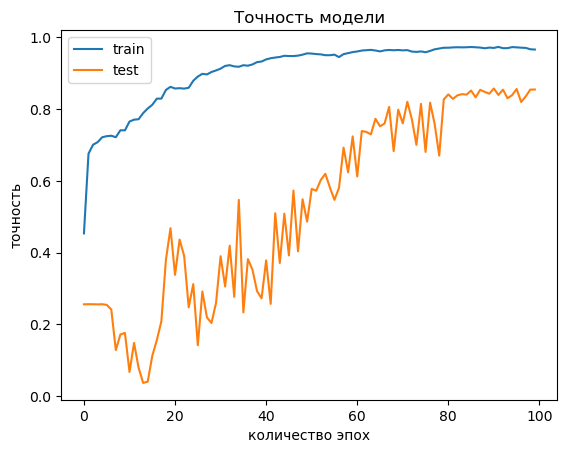

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Точность модели')
plt.ylabel('точность')
plt.xlabel('количество эпох')
plt.legend(['train', 'test'], loc='upper left');

### predict для двух тестовых картинок

In [19]:
# Делаем сегментацию для двух тестовых картинок
out = model.predict(X_test_pred[:2], batch_size=1)

2/2 [==============================] - 1s 268ms/step


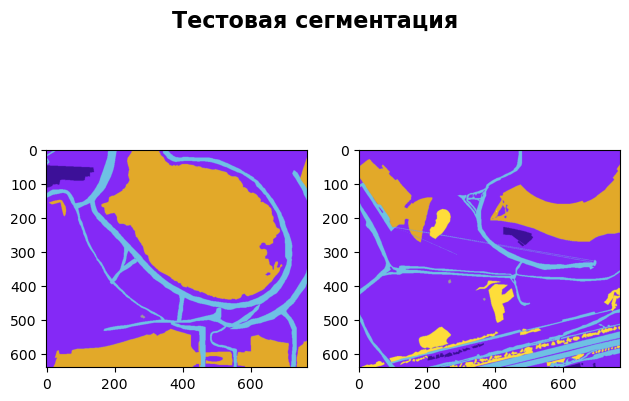

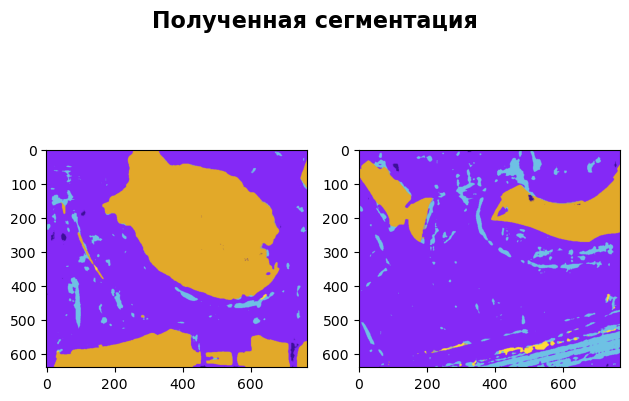

In [24]:
# 2-е тестовые картинки
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(convert_to_color(np.argmax(Y_test_pred[i], axis=-1)))
plt.suptitle('Тестовая сегментация', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show();

# 2-е картинки полученые методом predict
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(convert_to_color(np.argmax(out[i], axis=-1)))
plt.suptitle('Полученная сегментация', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show();

Точность модели 0.8546 при 100 эпохах обучения.  
Полученный результат сегментации очень похож на тестовый.